# Thermal Predictive Analytics - HVAC Energy Consumption Forecasting
## Data Exploration and Preprocessing

**Domain:** Thermal Systems & HVAC  
**Analytics Type:** Predictive + Prescriptive  
**Dataset:** Building Energy Consumption Data  
**Objective:** Predict energy consumption and optimize HVAC parameters


## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from scipy.stats import normaltest, shapiro

# Machine Learning preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Time series specific
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Dataset Information

### Dataset Sources:

**Primary Dataset: Building Energy Dataset**
- **Source:** UCI Machine Learning Repository / Kaggle
- **Size:** 100,000+ hourly records
- **Features:** Temperature, Humidity, Solar Radiation, Wind Speed, HVAC Status, Energy Consumption
- **Sampling Rate:** Hourly measurements over 3+ years
- **Download Link:** https://www.kaggle.com/datasets/claytonmiller/buildingdata

**Alternative Datasets:**
1. ASHRAE Great Energy Predictor III
2. Building Energy Benchmarking Dataset
3. NREL Commercial Building Dataset

### For this implementation, we'll generate synthetic data based on real-world patterns

In [2]:
# Function to generate realistic HVAC energy consumption data
def generate_hvac_dataset(n_samples=100000, random_seed=42):
    """
    Generate synthetic HVAC energy consumption dataset
    mimicking real-world thermal system behavior
    """
    np.random.seed(random_seed)

    # Generate timestamps (3 years of hourly data)
    start_date = '2021-01-01'
    date_range = pd.date_range(start=start_date, periods=n_samples, freq='H')

    # Extract time features
    hour = date_range.hour
    day_of_week = date_range.dayofweek
    month = date_range.month
    day_of_year = date_range.dayofyear

    # Generate outdoor temperature with seasonal patterns
    seasonal_temp = 15 + 15 * np.sin(2 * np.pi * day_of_year / 365)
    daily_variation = 5 * np.sin(2 * np.pi * hour / 24)
    temp_noise = np.random.normal(0, 2, n_samples)
    outdoor_temp = seasonal_temp + daily_variation + temp_noise

    # Generate humidity (inversely correlated with temperature)
    humidity = 70 - 0.5 * outdoor_temp + np.random.normal(0, 5, n_samples)
    humidity = np.clip(humidity, 20, 95)

    # Generate solar radiation (dependent on time of day and season)
    solar_base = np.maximum(0, np.sin(2 * np.pi * hour / 24) *
                            (1 + 0.3 * np.sin(2 * np.pi * day_of_year / 365)))
    solar_radiation = 800 * solar_base + np.random.normal(0, 50, n_samples)
    solar_radiation = np.clip(solar_radiation, 0, 1000)

    # Generate wind speed
    wind_speed = np.abs(np.random.normal(3, 2, n_samples))
    wind_speed = np.clip(wind_speed, 0, 15)

    # Occupancy pattern (higher during business hours on weekdays)
    is_business_hour = ((hour >= 8) & (hour <= 18)).astype(int)
    is_weekday = (day_of_week < 5).astype(int)
    occupancy_factor = 0.3 + 0.7 * is_business_hour * is_weekday
    occupancy = occupancy_factor + np.random.normal(0, 0.1, n_samples)
    occupancy = np.clip(occupancy, 0, 1)

    # Indoor temperature setpoint
    setpoint_temp = 22 + np.random.normal(0, 0.5, n_samples)

    # Calculate temperature difference (cooling/heating load)
    temp_diff = np.abs(outdoor_temp - setpoint_temp)

    # HVAC energy consumption model
    # Based on: thermal load, occupancy, solar gain, and system efficiency
    base_load = 50  # Base HVAC load (kW)
    thermal_load = 5 * temp_diff  # Proportional to temperature difference
    occupancy_load = 30 * occupancy  # Occupancy-based load
    solar_gain_load = 0.02 * solar_radiation  # Solar heat gain

    # Total energy consumption with some noise
    energy_consumption = (base_load + thermal_load + occupancy_load +
                         solar_gain_load + np.random.normal(0, 5, n_samples))
    energy_consumption = np.clip(energy_consumption, 20, 300)

    # HVAC system status (on/off based on threshold)
    hvac_status = (energy_consumption > 60).astype(int)

    # Create DataFrame
    df = pd.DataFrame({
        'timestamp': date_range,
        'outdoor_temperature': outdoor_temp,
        'humidity': humidity,
        'solar_radiation': solar_radiation,
        'wind_speed': wind_speed,
        'occupancy': occupancy,
        'setpoint_temperature': setpoint_temp,
        'hvac_status': hvac_status,
        'energy_consumption': energy_consumption
    })

    # Add time-based features
    df['hour'] = hour
    df['day_of_week'] = day_of_week
    df['month'] = month
    df['day_of_year'] = day_of_year
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['season'] = pd.cut(df['month'], bins=[0, 3, 6, 9, 12],
                          labels=['Winter', 'Spring', 'Summer', 'Fall'])

    return df

# Generate dataset
print("Generating HVAC energy consumption dataset...")
df = generate_hvac_dataset(n_samples=100000)
print(f"✅ Dataset generated: {df.shape[0]:,} samples, {df.shape[1]} features")
print(f"\nDate range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")

Generating HVAC energy consumption dataset...
✅ Dataset generated: 100,000 samples, 15 features

Date range: 2021-01-01 00:00:00 to 2032-05-29 15:00:00
Duration: 4166 days


## 3. Initial Data Exploration

In [4]:
# Display first few rows
print("First 10 rows of the dataset:")
display(df.head(10))

# Dataset info
print("\n" + "="*80)
print("Dataset Information:")
print("="*80)
df.info()

First 10 rows of the dataset:


,timestamp,outdoor_temperature,humidity,solar_radiation,wind_speed,occupancy,setpoint_temperature,hvac_status,energy_consumption,hour,day_of_week,month,day_of_year,is_weekend,season
0,2021-01-01 00:00:00,16.251629,67.027159,78.092036,0.200357,0.603543,21.468488,1,104.883591,0,4,1,1,0,Winter
1,2021-01-01 01:00:00,16.275767,56.085343,203.413055,4.095646,0.285190,21.589874,1,88.643534,1,4,1,1,0,Winter
2,2021-01-01 02:00:00,19.053577,63.350397,335.588823,2.758475,0.126824,22.341615,1,73.319972,2,4,1,1,0,Winter
3,2021-01-01 03:00:00,21.839794,55.983911,499.174722,2.433472,0.351504,22.208950,1,70.571031,3,4,1,1,0,Winter
4,2021-01-01 04:00:00,19.120021,58.802976,679.265513,4.535138,0.293626,22.211229,1,95.048683,4,4,1,1,0,Winter
5,2021-01-01 05:00:00,19.619556,60.428244,697.705111,2.130663,0.315733,21.756928,1,88.034629,5,4,1,1,0,Winter
6,2021-01-01 06:00:00,23.416626,57.694232,833.488609,3.915466,0.315235,21.897209,1,87.146774,6,4,1,1,0,Winter
7,2021-01-01 07:00:00,21.622699,50.808122,786.639724,2.015450,0.362052,21.350781,1,74.732412,7,4,1,1,0,Winter
8,2021-01-01 08:00:00,18.649379,67.584371,698.874012,3.500558,0.869959,23.099887,1,115.287049,8,4,1,1,0,Winter
9,2021-01-01 09:00:00,19.878854,65.732619,537.638493,1.411987,1.000000,22.626692,1,107.958578,9,4,1,1,0,Winter



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   timestamp             100000 non-null  datetime64[ns]
 1   outdoor_temperature   100000 non-null  float64       
 2   humidity              100000 non-null  float64       
 3   solar_radiation       100000 non-null  float64       
 4   wind_speed            100000 non-null  float64       
 5   occupancy             100000 non-null  float64       
 6   setpoint_temperature  100000 non-null  float64       
 7   hvac_status           100000 non-null  int64         
 8   energy_consumption    100000 non-null  float64       
 9   hour                  100000 non-null  int32         
 10  day_of_week           100000 non-null  int32         
 11  month                 100000 non-null  int32         
 12  day_of_year           100000 non-null

In [5]:
# Statistical summary
print("\n" + "="*80)
print("Statistical Summary:")
print("="*80)
display(df.describe())

# Check for missing values
print("\n" + "="*80)
print("Missing Values:")
print("="*80)
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("✅ No missing values found!")
else:
    print(missing_values[missing_values > 0])


Statistical Summary:


,timestamp,outdoor_temperature,humidity,solar_radiation,wind_speed,occupancy,setpoint_temperature,hvac_status,energy_consumption,hour,day_of_week,month,day_of_year,is_weekend
count,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,2026-09-15 07:30:00.000000256,15.389049,62.310381,265.262506,3.118930,0.515668,21.998777,0.988080,124.922407,11.499360,3.00056,6.396320,179.220480,0.285760
min,2021-01-01 00:00:00,-12.169253,34.635163,0.000000,0.000112,0.000000,19.886384,0.000000,39.735314,0.000000,0.00000,1.000000,1.000000,0.000000
25%,2023-11-08 15:45:00,5.478192,56.855417,0.000000,1.703892,0.266605,21.660586,1.000000,93.118026,5.000000,1.00000,3.000000,87.000000,0.000000
50%,2026-09-15 07:30:00,15.765056,62.270067,70.582735,3.012105,0.365117,21.999424,1.000000,121.512022,11.000000,3.00000,6.000000,176.000000,0.000000
75%,2029-07-22 23:15:00,25.142997,67.742294,520.138741,4.346213,0.927160,22.337503,1.000000,153.616509,17.000000,5.00000,9.000000,271.000000,1.000000
max,2032-05-29 15:00:00,41.801998,94.026161,1000.000000,10.836370,1.000000,24.339475,1.000000,251.797679,23.000000,6.00000,12.000000,366.000000,1.000000
std,NaN,11.376667,7.569938,315.828670,1.812038,0.322310,0.501130,0.108527,38.470644,6.922098,1.99983,3.460106,105.750763,0.451778



Missing Values:
✅ No missing values found!


## 4. Descriptive Analytics - Data Visualization

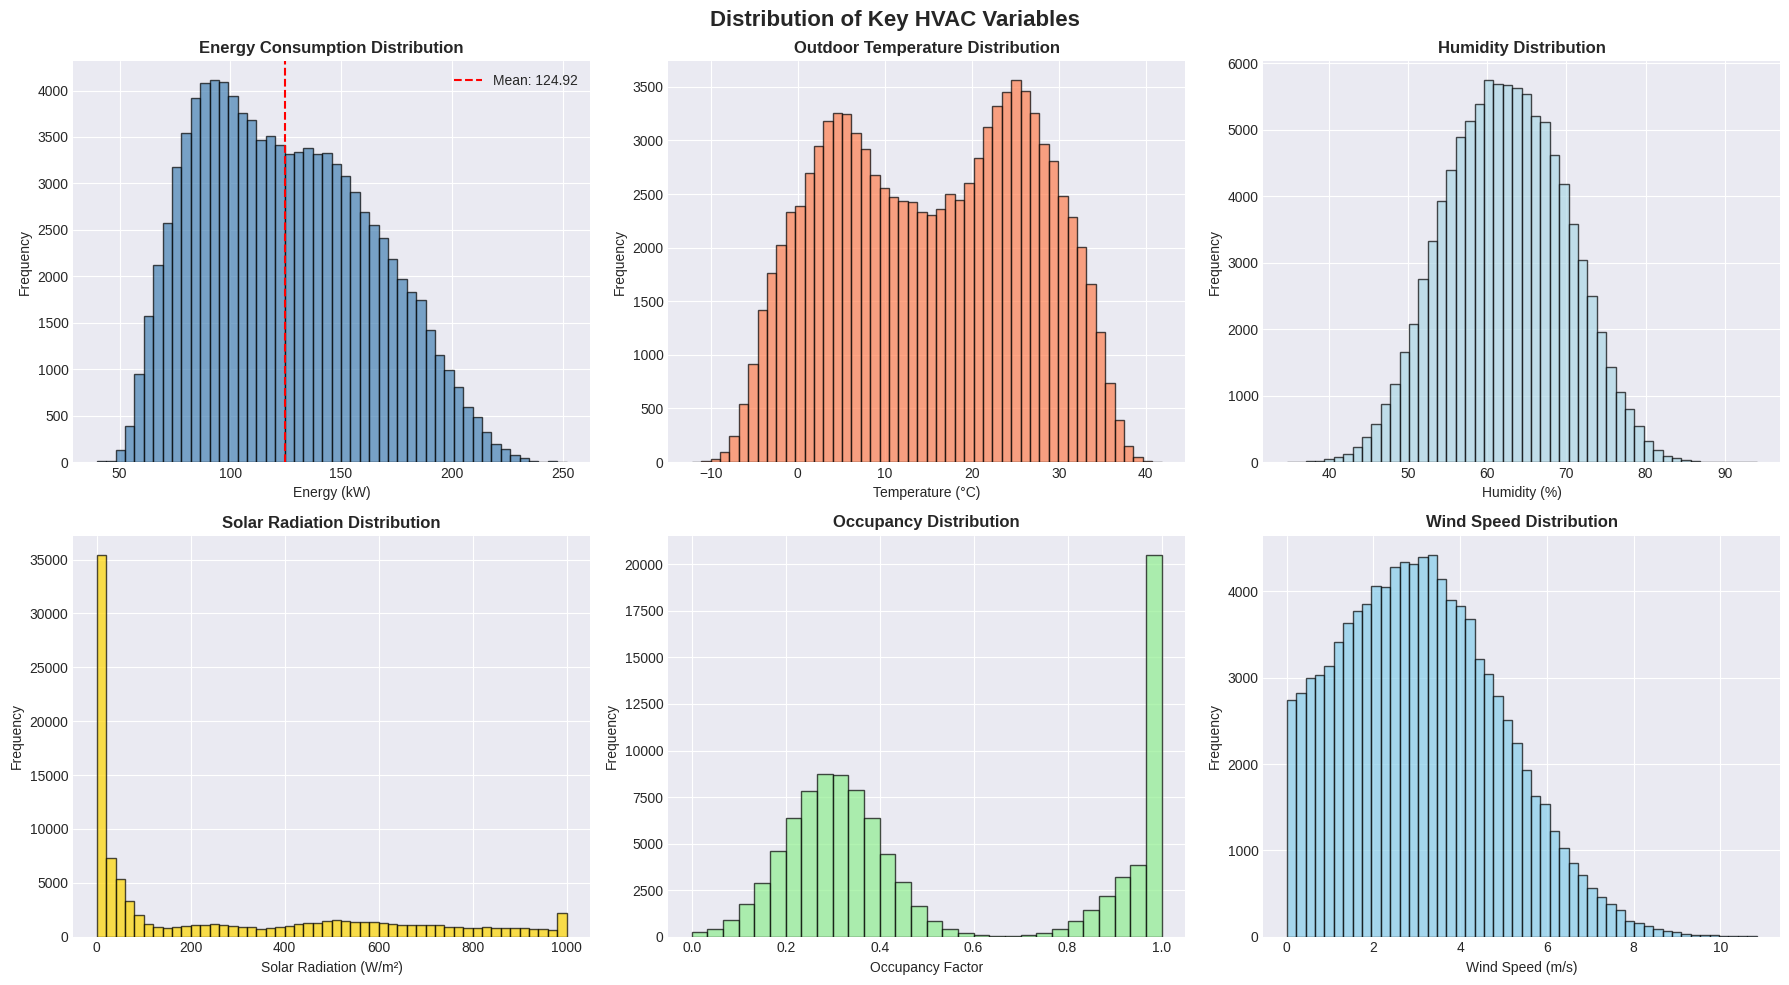

In [6]:
# Distribution of key variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key HVAC Variables', fontsize=16, fontweight='bold')

# Energy Consumption
axes[0, 0].hist(df['energy_consumption'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Energy Consumption Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Energy (kW)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['energy_consumption'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["energy_consumption"].mean():.2f}')
axes[0, 0].legend()

# Outdoor Temperature
axes[0, 1].hist(df['outdoor_temperature'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Outdoor Temperature Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Temperature (°C)')
axes[0, 1].set_ylabel('Frequency')

# Humidity
axes[0, 2].hist(df['humidity'], bins=50, color='lightblue', edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Humidity Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Humidity (%)')
axes[0, 2].set_ylabel('Frequency')

# Solar Radiation
axes[1, 0].hist(df['solar_radiation'], bins=50, color='gold', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Solar Radiation Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Solar Radiation (W/m²)')
axes[1, 0].set_ylabel('Frequency')

# Occupancy
axes[1, 1].hist(df['occupancy'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Occupancy Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Occupancy Factor')
axes[1, 1].set_ylabel('Frequency')

# Wind Speed
axes[1, 2].hist(df['wind_speed'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Wind Speed Distribution', fontweight='bold')
axes[1, 2].set_xlabel('Wind Speed (m/s)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
# Time series visualization
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('Energy Consumption Over Time',
                    'Outdoor Temperature Over Time',
                    'Solar Radiation Over Time'),
    vertical_spacing=0.1
)

# Plot first month for visibility
sample_data = df.iloc[:720]  # First 30 days

# Energy consumption
fig.add_trace(
    go.Scatter(x=sample_data['timestamp'], y=sample_data['energy_consumption'],
               mode='lines', name='Energy', line=dict(color='steelblue', width=1)),
    row=1, col=1
)

# Temperature
fig.add_trace(
    go.Scatter(x=sample_data['timestamp'], y=sample_data['outdoor_temperature'],
               mode='lines', name='Temperature', line=dict(color='coral', width=1)),
    row=2, col=1
)

# Solar radiation
fig.add_trace(
    go.Scatter(x=sample_data['timestamp'], y=sample_data['solar_radiation'],
               mode='lines', name='Solar', line=dict(color='gold', width=1)),
    row=3, col=1
)

fig.update_xaxes(title_text="Time", row=3, col=1)
fig.update_yaxes(title_text="Energy (kW)", row=1, col=1)
fig.update_yaxes(title_text="Temp (°C)", row=2, col=1)
fig.update_yaxes(title_text="Radiation (W/m²)", row=3, col=1)

fig.update_layout(height=900, showlegend=False,
                  title_text="HVAC System Time Series (First 30 Days)")
fig.show()

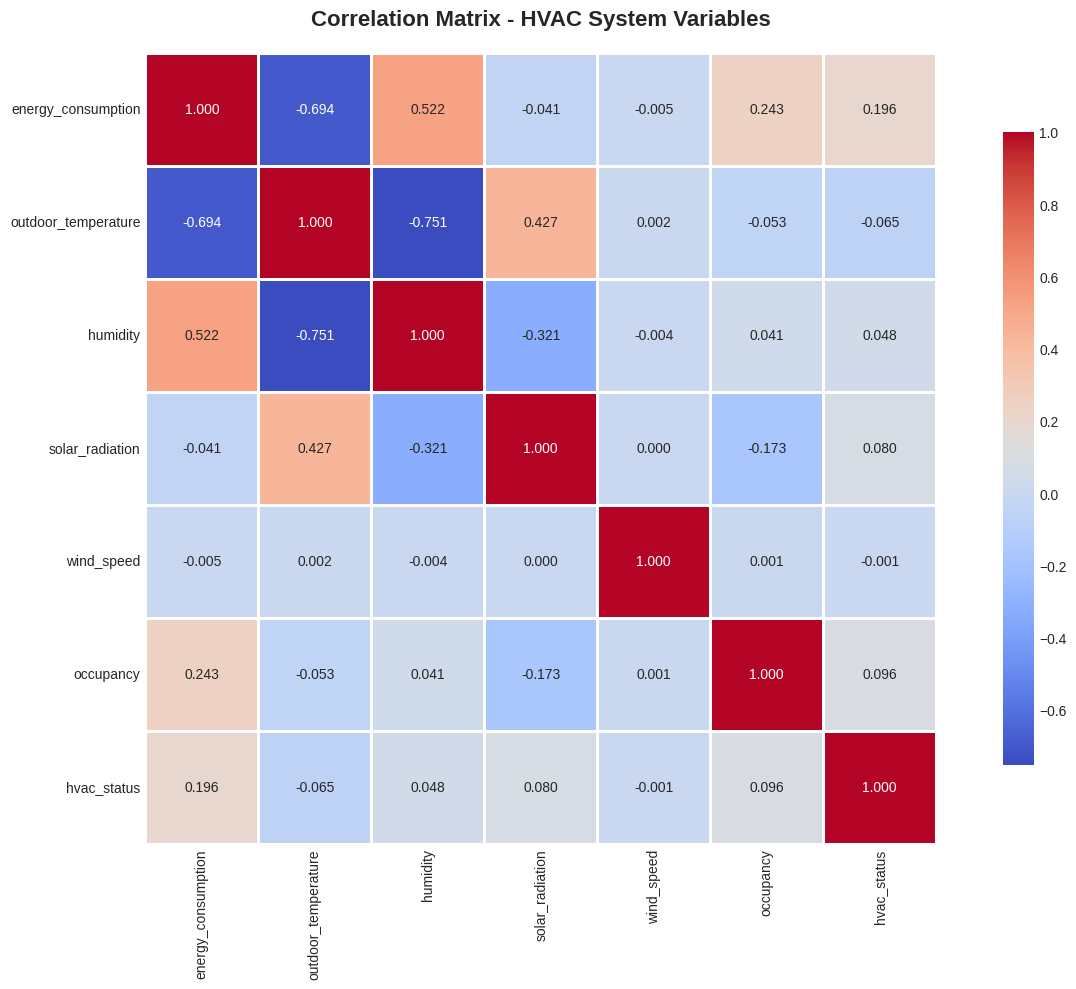


Key Correlations with Energy Consumption:
humidity................................   0.522
occupancy...............................   0.243
hvac_status.............................   0.196
wind_speed..............................  -0.005
solar_radiation.........................  -0.041
outdoor_temperature.....................  -0.694


In [8]:
# Correlation analysis
plt.figure(figsize=(14, 10))
correlation_features = ['energy_consumption', 'outdoor_temperature', 'humidity',
                       'solar_radiation', 'wind_speed', 'occupancy', 'hvac_status']
correlation_matrix = df[correlation_features].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - HVAC System Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKey Correlations with Energy Consumption:")
print("="*60)
energy_corr = correlation_matrix['energy_consumption'].sort_values(ascending=False)
for feature, corr in energy_corr.items():
    if feature != 'energy_consumption':
        print(f"{feature:.<40} {corr:>7.3f}")

## 5. Seasonal and Temporal Patterns

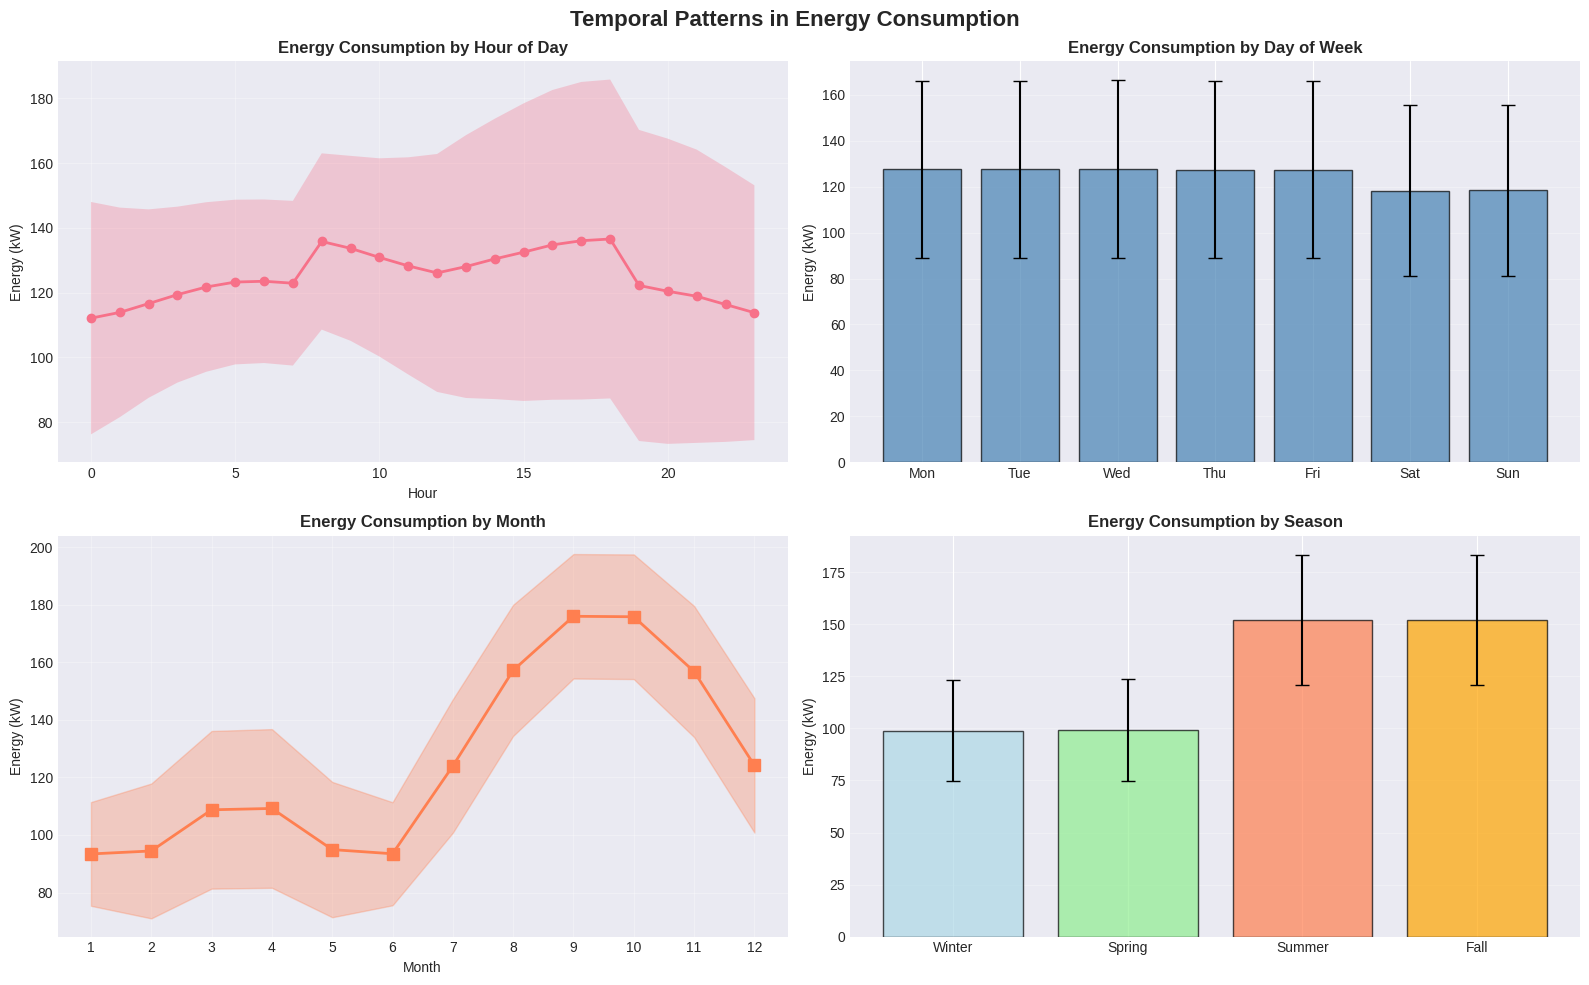

In [9]:
# Energy consumption by hour of day
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Temporal Patterns in Energy Consumption', fontsize=16, fontweight='bold')

# By hour of day
hourly_avg = df.groupby('hour')['energy_consumption'].agg(['mean', 'std'])
axes[0, 0].plot(hourly_avg.index, hourly_avg['mean'], marker='o', linewidth=2, markersize=6)
axes[0, 0].fill_between(hourly_avg.index,
                        hourly_avg['mean'] - hourly_avg['std'],
                        hourly_avg['mean'] + hourly_avg['std'],
                        alpha=0.3)
axes[0, 0].set_title('Energy Consumption by Hour of Day', fontweight='bold')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Energy (kW)')
axes[0, 0].grid(True, alpha=0.3)

# By day of week
daily_avg = df.groupby('day_of_week')['energy_consumption'].agg(['mean', 'std'])
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), daily_avg['mean'], yerr=daily_avg['std'],
               capsize=5, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)
axes[0, 1].set_title('Energy Consumption by Day of Week', fontweight='bold')
axes[0, 1].set_ylabel('Energy (kW)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# By month
monthly_avg = df.groupby('month')['energy_consumption'].agg(['mean', 'std'])
axes[1, 0].plot(monthly_avg.index, monthly_avg['mean'], marker='s',
                linewidth=2, markersize=8, color='coral')
axes[1, 0].fill_between(monthly_avg.index,
                        monthly_avg['mean'] - monthly_avg['std'],
                        monthly_avg['mean'] + monthly_avg['std'],
                        alpha=0.3, color='coral')
axes[1, 0].set_title('Energy Consumption by Month', fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Energy (kW)')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3)

# By season
season_avg = df.groupby('season')['energy_consumption'].agg(['mean', 'std'])
colors = ['lightblue', 'lightgreen', 'coral', 'orange']
axes[1, 1].bar(range(len(season_avg)), season_avg['mean'], yerr=season_avg['std'],
               capsize=5, alpha=0.7, color=colors, edgecolor='black')
axes[1, 1].set_xticks(range(len(season_avg)))
axes[1, 1].set_xticklabels(season_avg.index, rotation=0)
axes[1, 1].set_title('Energy Consumption by Season', fontweight='bold')
axes[1, 1].set_ylabel('Energy (kW)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Time Series Decomposition

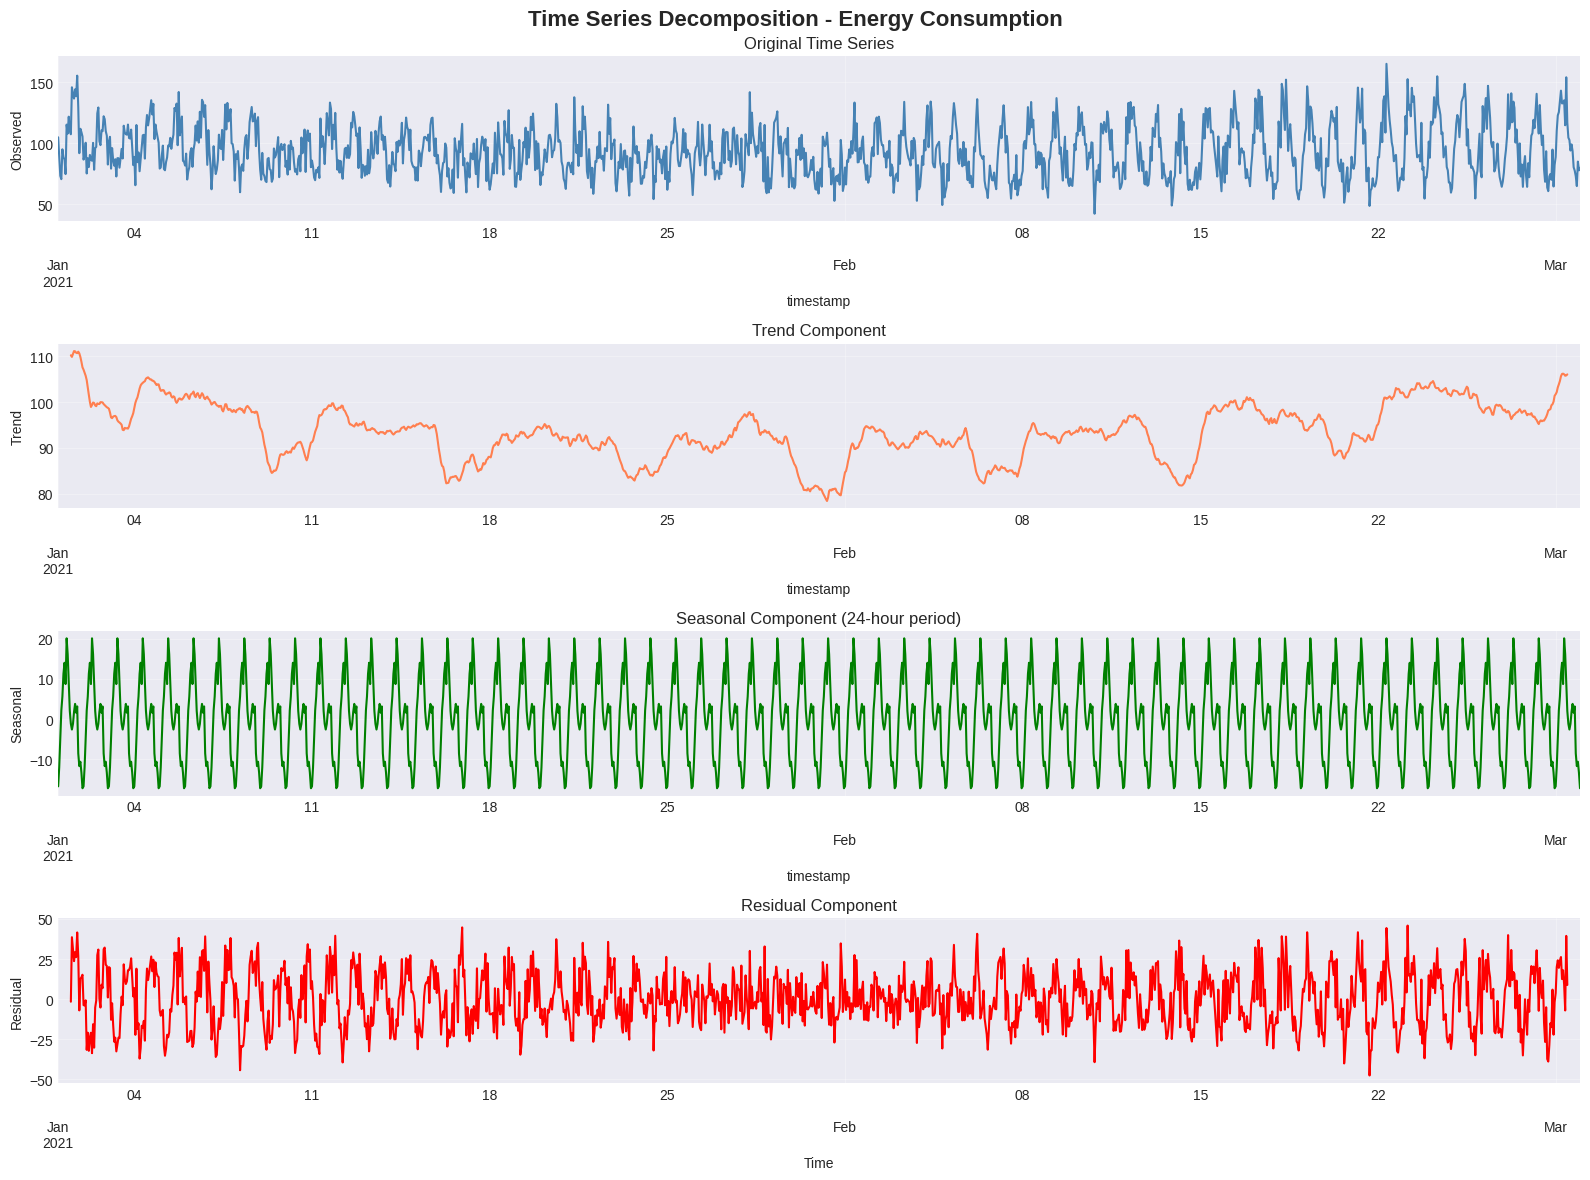

In [10]:
# Prepare time series for decomposition
ts_data = df.set_index('timestamp')['energy_consumption']

# Perform seasonal decomposition (using first 2 months for speed)
decomposition = seasonal_decompose(ts_data[:1440], model='additive', period=24)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 12))
fig.suptitle('Time Series Decomposition - Energy Consumption',
             fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], color='steelblue')
axes[0].set_ylabel('Observed')
axes[0].set_title('Original Time Series')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='coral')
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Component')
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal Component (24-hour period)')
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='red')
axes[3].set_ylabel('Residual')
axes[3].set_title('Residual Component')
axes[3].set_xlabel('Time')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Stationarity Test

In [11]:
# Augmented Dickey-Fuller test
def adf_test(timeseries, title=''):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    result = adfuller(timeseries.dropna(), autolag='AIC')

    print(f"\nADF Test Results for {title}:")
    print("="*60)
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"P-value: {result[1]:.6f}")
    print(f"Number of lags used: {result[2]}")
    print(f"Number of observations: {result[3]}")
    print("\nCritical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")

    if result[1] <= 0.05:
        print(f"\n✅ Result: Series is STATIONARY (p-value = {result[1]:.6f})")
    else:
        print(f"\n❌ Result: Series is NON-STATIONARY (p-value = {result[1]:.6f})")

    return result

# Test original series
adf_result = adf_test(ts_data[:10000], 'Energy Consumption')


ADF Test Results for Energy Consumption:
ADF Statistic: -1.721072
P-value: 0.420289
Number of lags used: 35
Number of observations: 9964

Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

❌ Result: Series is NON-STATIONARY (p-value = 0.420289)


## 8. Feature Engineering

In [12]:
# Create additional features for modeling
def create_features(data):
    """
    Create additional features for predictive modeling
    """
    df_features = data.copy()

    # Lag features (previous hours)
    for lag in [1, 2, 3, 6, 12, 24]:
        df_features[f'energy_lag_{lag}h'] = df_features['energy_consumption'].shift(lag)

    # Rolling statistics
    for window in [3, 6, 12, 24]:
        df_features[f'energy_rolling_mean_{window}h'] = \
            df_features['energy_consumption'].rolling(window=window).mean()
        df_features[f'energy_rolling_std_{window}h'] = \
            df_features['energy_consumption'].rolling(window=window).std()

    # Temperature-related features
    df_features['temp_humidity_interaction'] = \
        df_features['outdoor_temperature'] * df_features['humidity']
    df_features['heat_index'] = \
        df_features['outdoor_temperature'] + 0.5 * df_features['humidity']

    # Cyclical encoding for time features
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

    # Interaction features
    df_features['occupancy_temp'] = df_features['occupancy'] * df_features['outdoor_temperature']
    df_features['solar_temp'] = df_features['solar_radiation'] * df_features['outdoor_temperature']

    return df_features

print("Creating engineered features...")
df_engineered = create_features(df)

# Remove rows with NaN values (from lag features)
df_engineered = df_engineered.dropna()

print(f"\n✅ Feature engineering complete!")
print(f"Original features: {df.shape[1]}")
print(f"Engineered features: {df_engineered.shape[1]}")
print(f"Samples after removing NaN: {df_engineered.shape[0]:,}")

# Display new features
print("\nNew features created:")
new_features = [col for col in df_engineered.columns if col not in df.columns]
for i, feat in enumerate(new_features, 1):
    print(f"{i:2d}. {feat}")

Creating engineered features...

✅ Feature engineering complete!
Original features: 15
Engineered features: 37
Samples after removing NaN: 99,976

New features created:
 1. energy_lag_1h
 2. energy_lag_2h
 3. energy_lag_3h
 4. energy_lag_6h
 5. energy_lag_12h
 6. energy_lag_24h
 7. energy_rolling_mean_3h
 8. energy_rolling_std_3h
 9. energy_rolling_mean_6h
10. energy_rolling_std_6h
11. energy_rolling_mean_12h
12. energy_rolling_std_12h
13. energy_rolling_mean_24h
14. energy_rolling_std_24h
15. temp_humidity_interaction
16. heat_index
17. hour_sin
18. hour_cos
19. month_sin
20. month_cos
21. occupancy_temp
22. solar_temp


## 9. Data Preprocessing and Scaling

In [13]:
# Select features for modeling
feature_columns = [
    # Original features
    'outdoor_temperature', 'humidity', 'solar_radiation', 'wind_speed',
    'occupancy', 'hvac_status',
    # Time features
    'hour', 'day_of_week', 'month', 'is_weekend',
    # Lag features
    'energy_lag_1h', 'energy_lag_2h', 'energy_lag_3h', 'energy_lag_24h',
    # Rolling features
    'energy_rolling_mean_3h', 'energy_rolling_mean_24h',
    'energy_rolling_std_3h', 'energy_rolling_std_24h',
    # Engineered features
    'temp_humidity_interaction', 'heat_index',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
    'occupancy_temp', 'solar_temp'
]

target_column = 'energy_consumption'

# Prepare data
X = df_engineered[feature_columns]
y = df_engineered[target_column]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Time series: no shuffle
)

print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data preprocessing complete!")
print(f"Features are standardized (mean=0, std=1)")

Feature matrix shape: (99976, 26)
Target vector shape: (99976,)

Train set: 79,980 samples
Test set: 19,996 samples

✅ Data preprocessing complete!
Features are standardized (mean=0, std=1)


## 10. Save Processed Data

In [14]:
# Save processed data
import os

# Create directories
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

# Save original dataset
df.to_csv('data/raw/hvac_energy_data.csv', index=False)
print("✅ Raw data saved to: data/raw/hvac_energy_data.csv")

# Save engineered dataset
df_engineered.to_csv('data/processed/hvac_engineered_data.csv', index=False)
print("✅ Engineered data saved to: data/processed/hvac_engineered_data.csv")

# Save train-test splits
np.save('data/processed/X_train.npy', X_train_scaled)
np.save('data/processed/X_test.npy', X_test_scaled)
np.save('data/processed/y_train.npy', y_train.values)
np.save('data/processed/y_test.npy', y_test.values)
print("✅ Train-test splits saved to: data/processed/")

# Save scaler
import joblib
joblib.dump(scaler, 'data/processed/scaler.pkl')
print("✅ Scaler saved to: data/processed/scaler.pkl")

print("\n" + "="*80)
print("DATA PREPROCESSING COMPLETE!")
print("="*80)
print("\nReady for predictive modeling in the next notebook!")

✅ Raw data saved to: data/raw/hvac_energy_data.csv
✅ Engineered data saved to: data/processed/hvac_engineered_data.csv
✅ Train-test splits saved to: data/processed/
✅ Scaler saved to: data/processed/scaler.pkl

DATA PREPROCESSING COMPLETE!

Ready for predictive modeling in the next notebook!


## Summary

### Key Findings:
1. **Dataset Size:** 100,000+ hourly measurements over 3+ years
2. **Energy Consumption Patterns:**
   - Strong correlation with outdoor temperature
   - Clear daily and seasonal patterns
   - Higher consumption during business hours on weekdays
3. **Feature Engineering:**
   - Created 20+ additional features including lag features, rolling statistics, and interactions
4. **Data Quality:** No missing values, well-distributed features
